Variables:              
- dat_tr - data per one trial (one regione of one mouse, just white noise)            
- dat_stan/aw - data per one state of the mouse (anest/awake)              
- dat_sean/aw - data per session                   
- df_corr_an/aw - dataframe of correlation (correlation matrix)
- top50_change_tr - info: num_tr, mouse, region, session, position

##### Importing required packages and libraries 

In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cmath import nan
from sklearn.metrics import confusion_matrix

##### Loading .mat files - respPeak = peak of ind, allROIPositions

In [3]:
mat_load = sio.loadmat('C:/Users/Zephyrus/Desktop/respPeak.mat')['x']
roi_load = sio.loadmat('C:/Users/Zephyrus/Desktop/allROIPositions.mat')['allROIPositions']
ind_load = sio.loadmat('C:/Users/Zephyrus/Desktop/blFinalHit.mat')['blFinalHit']

In [4]:
list1 = sio.loadmat('C:/Users/Zephyrus/Desktop/indicesSession1.mat')['indSess1']
list2 = sio.loadmat('C:/Users/Zephyrus/Desktop/List2.mat')['List2']
list3 = sio.loadmat('C:/Users/Zephyrus/Desktop/List3.mat')['List3']
list4 = sio.loadmat('C:/Users/Zephyrus/Desktop/List4.mat')['List4']

In [5]:
tune1 = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneSpec1.mat')['tuneSpecificity1']
tune2 = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneSpec2.mat')['tuneSpecificity2']
tune3 = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneSpec3.mat')['tuneSpecificity3']
tune4 = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneSpec4.mat')['tuneSpecificity4']

In [6]:
tune1_cat = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneCat1.mat')['tuneCat1']
tune2_cat = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneCat2.mat')['tuneCat2']
tune3_cat = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneCat3.mat')['tuneCat3']
tune4_cat = sio.loadmat('C:/Users/Zephyrus/Desktop/tuneCat4.mat')['tuneCat4']

In [7]:
lista = [[k[0] for k in list1], [k[0] for k in list2], [k[0] for k in list3], [k[0] for k in list4]]
tune = [tune1, tune2, tune3, tune4]
tune_cat = [tune1_cat, tune2_cat, tune3_cat, tune4_cat]

##### General functions

In [8]:
#Dividing data into trials, anst state and awake state

def divide_data(index, trial, mat_load, ind_load):

    index[trial] = index[trial] + index[trial-1]
    dat_tr = mat_load[index[trial-1] : index[trial]+1, :, :, 0, :, :]
    ind_tr = ind_load[index[trial-1] : index[trial]+1, :, :, 0, :, :]

    #choose state
    dat_stan = dat_tr[:, 0, :, :, :]
    dat_staw = dat_tr[:, 1, :, :, :]
    ind_stan = ind_tr[:, 0, :, :, :]
    ind_staw = ind_tr[:, 1, :, :, :]
    
    return index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw

In [9]:
#make dict to convert to dataframe and computing correlation

def make_dict(index, trial, lista, dat_sean, dat_seaw, ind_sean, ind_seaw):

    dat_df_an = []
    dat_df_aw = []
    ind_df_an = []
    ind_df_aw = []
    for matrix in range(0,np.shape(dat_sean)[0]-1):
        if(index[trial-1]+matrix in lista):
            dat_df_an.append(dat_sean[matrix].flatten())
            dat_df_aw.append(dat_seaw[matrix].flatten())
            ind_df_an.append(ind_sean[matrix].flatten())
            ind_df_aw.append(ind_seaw[matrix].flatten())
    dat_df_an = pd.DataFrame(dat_df_an)*pd.DataFrame(ind_df_an)
    dat_df_aw = pd.DataFrame(dat_df_aw)*pd.DataFrame(ind_df_aw)
    dat_df_an = dat_df_an.T.corr()
    dat_df_aw = dat_df_aw.T.corr()
    return dat_df_an, dat_df_aw

def make_dict_one_speaker(index, trial, lista, dat_sean, dat_seaw, num, ind_sean, ind_seaw):
    
    dat_df_an = []
    dat_df_aw = []
    ind_df_an = []
    ind_df_aw = []
    for matrix in range(0,np.shape(dat_sean)[0]-1):
        if(index[trial-1]+matrix in lista):
            dat_df_an.append(dat_sean[matrix][num])
            dat_df_aw.append(dat_seaw[matrix][num])
            ind_df_an.append(ind_sean[matrix][num])
            ind_df_aw.append(ind_seaw[matrix][num])
    dat_df_an = pd.DataFrame(dat_df_an)*pd.DataFrame(ind_df_an)
    dat_df_aw = pd.DataFrame(dat_df_aw)*pd.DataFrame(ind_df_aw)

    dat_df_an = pd.DataFrame(dat_df_an).T.corr()
    dat_df_aw = pd.DataFrame(dat_df_aw).T.corr()
    return dat_df_an, dat_df_aw

In [10]:
#exclude the rows/columns which index is not in the other dataframe
def exclude_nan(dat_df_an, dat_df_aw):

    df_corr_an = dat_df_an.dropna(how='all', axis=1).dropna(how='all', axis=0)
    df_corr_aw = dat_df_aw.dropna(how='all', axis=1).dropna(how='all', axis=0)

    mask = df_corr_aw.index.isin(df_corr_an.index)
    df_corr_aw = df_corr_aw.loc[mask]
    mask = df_corr_an.index.isin(df_corr_aw.index)
    df_corr_an = df_corr_an.loc[mask]
    mask = []
    for x in df_corr_an.columns:
        if x not in df_corr_aw.columns:
            mask.append(x)
    df_corr_an = df_corr_an.drop(columns=mask)
    mask = []
    for x in df_corr_aw.columns:
        if x not in df_corr_an.columns:
            mask.append(x)
    df_corr_aw = df_corr_aw.drop(columns=mask)

    return df_corr_an, df_corr_aw

##### Noise correlation of the neurons (first-anes, second-awake)

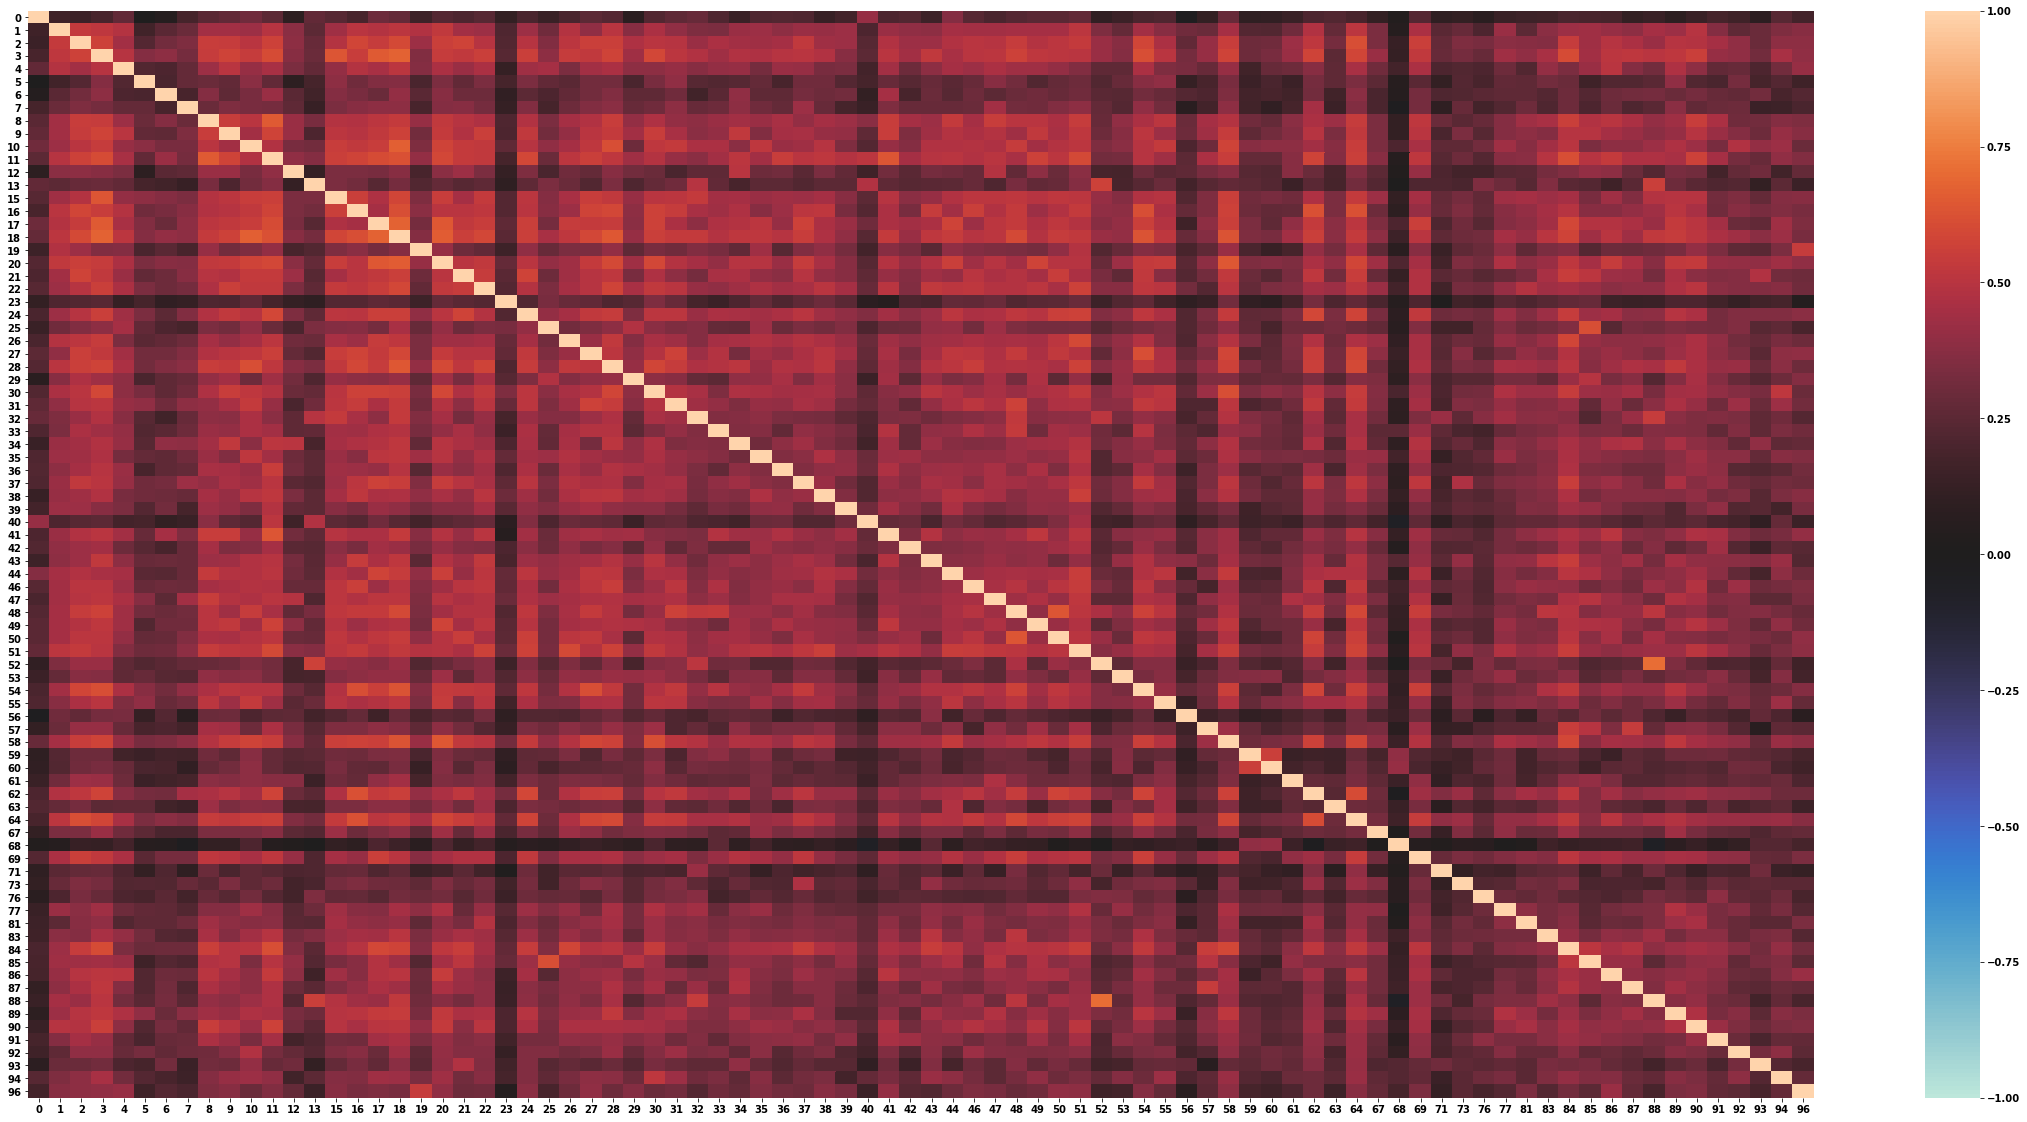

In [12]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):

        f,ax = plt.subplots(sharey=False,figsize=(40, 20))

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)
        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)
    
        #plot the correlation matrix
        sns.heatmap(df_corr_an, vmax=1, vmin=-1, center=0)
        
        #sns.heatmap(df_corr_aw, vmax=1, vmin=-1, ax=ax2)
        #print(pd.DataFrame(np.corrcoef(np.hstack((np.matrix(dat_df_an), np.matrix(dat_df_aw))),rowvar=False)[0,1:]))
        break
    break


##### Comparing correlation matrices in the anesthetized and in the awake state

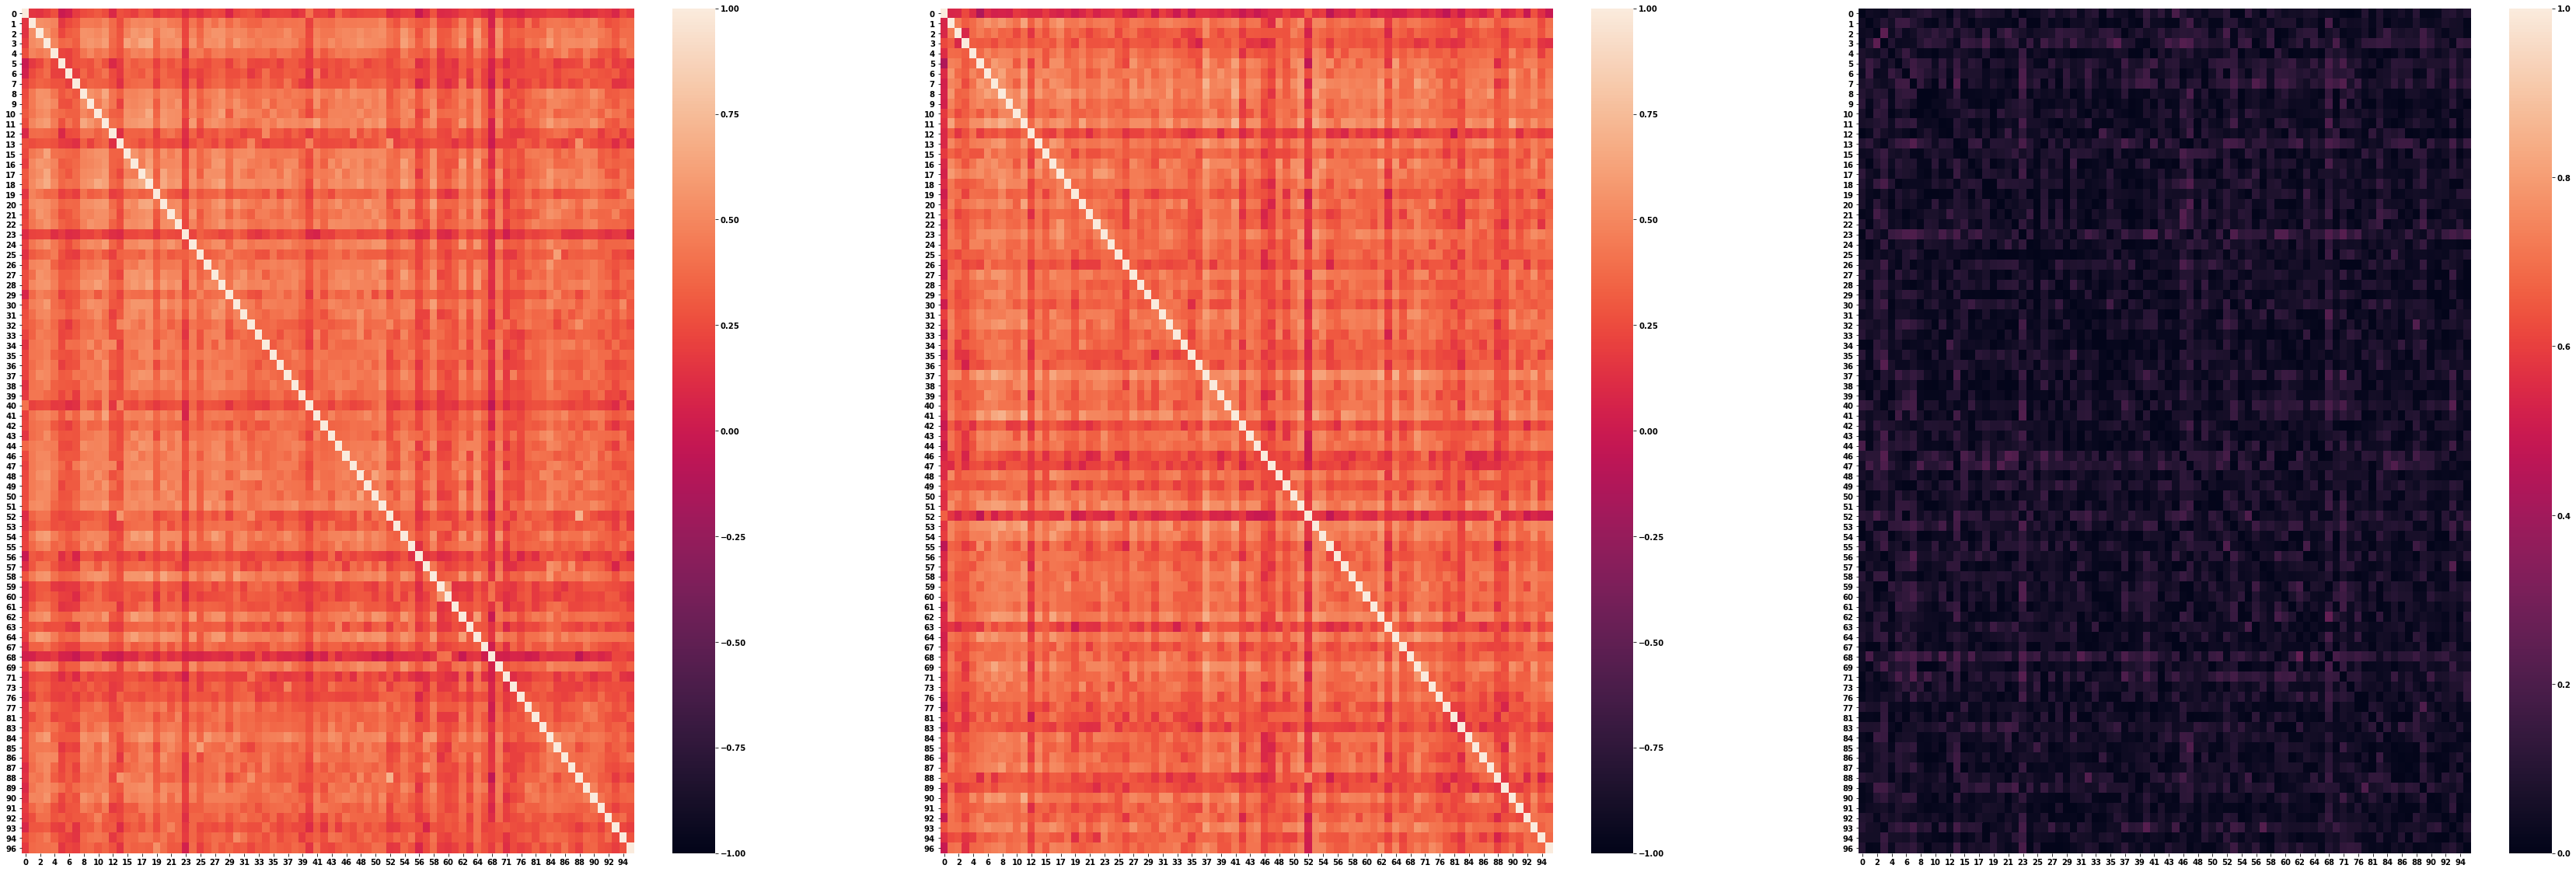

In [13]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):

        f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=False,figsize=(60, 20))

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        #difference between the two correlation matrices
        df_corr_diff = abs(df_corr_an - df_corr_aw)/2

        #plot the correlation matrix
        sns.heatmap(df_corr_an, vmax=1, vmin=-1, ax=ax1)
        sns.heatmap(df_corr_aw, vmax=1, vmin=-1, ax=ax2)
        sns.heatmap(df_corr_diff, vmax=1, vmin=0, ax=ax3)

        break
    break

##### Top 10 anticorrelated neurons (increase/decrease) per trial

In [14]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]
all_dict = []

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):
        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        #difference between the two correlation matrices
        df_corr_diff_inc = (df_corr_aw - df_corr_an)
        df_corr_diff_dec = (df_corr_an - df_corr_aw)
        
        #finding max differences in the whole dataframe
        top_inc = df_corr_diff_inc.stack().nlargest(20).index.tolist()
        del top_inc[1::2]
        top_dec = df_corr_diff_dec.stack().nlargest(20).index.tolist()
        del top_dec[1::2]
    
        #saving the data as dictionary
        top_change_tr = {}
        top_change_tr['inc'] = top_inc
        top_change_tr['inc_val'] = df_corr_diff_inc.stack().nlargest(20).values.tolist()[1::2]
        top_change_tr['dec'] = top_dec
        top_change_tr['dec_val'] = df_corr_diff_dec.stack().nlargest(20).values.tolist()[1::2]
        top_change_tr['tr'] = trial
        top_change_tr['mouse'] = (trial + 1)//2
        top_change_tr['region'] = 1 if(trial%2 != 0) else 2
        top_change_tr['ses'] = sesion + 1

        all_dict.append(top_change_tr)

        del top_inc, top_dec

##### Top 50 anticorrelated neurons overall

In [15]:
vals = []
info = []

for i in all_dict:
    for j in range(10):
        vals.append(i['inc_val'][j])
        info.append([i['tr'], i['mouse'], i['region'], i['ses'], i['inc'][j]])
    for j in range(10):
        vals.append(i['dec_val'][j])
        info.append([i['tr'], i['mouse'], i['region'], i['ses'], i['dec'][j]])

vals_sort = [x for x, y in sorted(zip(vals, info), reverse=True)]
info_sort = [y for x, y in sorted(zip(vals, info), reverse=True)]

top50_change_tr = {}
top50_change_tr['vals'] = vals_sort[:50]
top50_change_tr['info'] = info_sort[:50]

##### Cumulative plot of correlations /comparing/

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


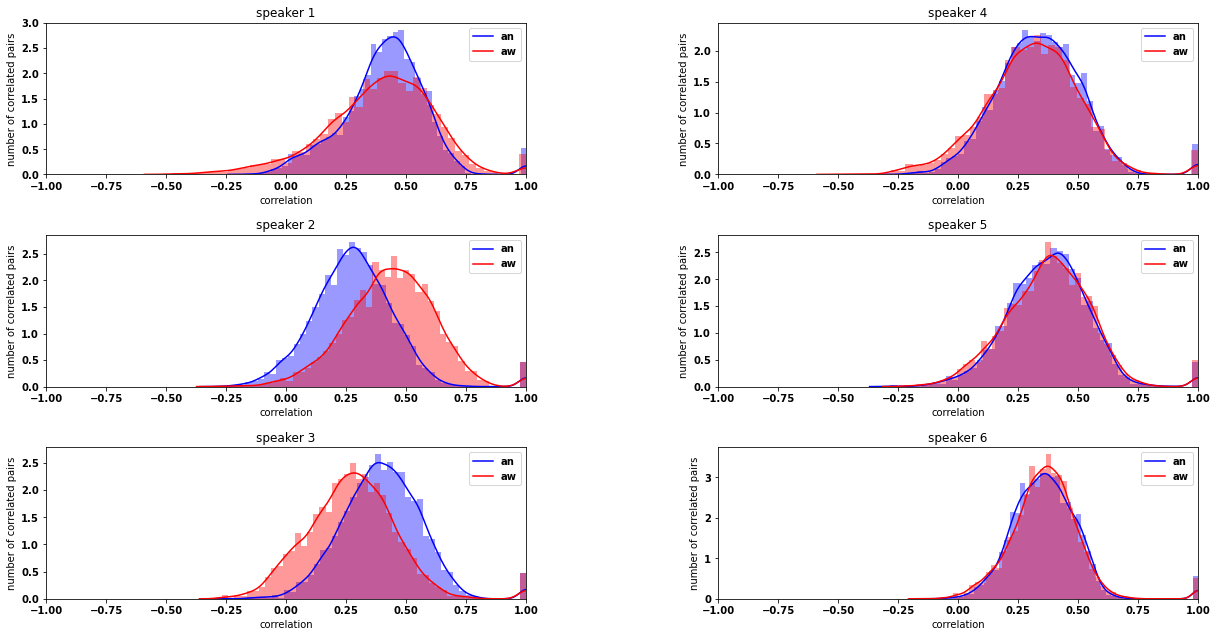

In [16]:
import warnings
warnings.filterwarnings('ignore')

#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #plot the correlation distribution
        f, ax = plt.subplots(3,2,figsize=(20, 10))
        for speaker in range(0,6):
            #make dict to convert to dataframe
            if(speaker==5):
                dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)
            else:
                dat_df_an, dat_df_aw = make_dict_one_speaker(index, trial, lista[sesion], dat_sean, dat_seaw, speaker, ind_sean, ind_seaw)

            #exclude the rows/columns which index is not in the other dataframe
            df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

            df_an_line = df_corr_an.unstack()
            so1 = df_an_line.sort_values(kind="quicksort")
            df_aw_line = df_corr_aw.unstack()
            so2 = df_aw_line.sort_values(kind="quicksort")

            
            ax[speaker%3][speaker//3].set_xlim([-1, 1])
            ax[speaker%3][speaker//3].set_xlabel('correlation')
            ax[speaker%3][speaker//3].set_ylabel('number of correlated pairs')
            ax[speaker%3][speaker//3].set_title('speaker ' + str(speaker+1))
            
            sns.distplot(so1, hist=True, color="b", ax=ax[speaker%3][speaker//3])
            sns.distplot(so2, hist=True, color="r", ax=ax[speaker%3][speaker//3])
            ax[speaker%3][speaker//3].legend(['an', 'aw'])
            plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
                    
        break
    break

##### Cumulative plot of correlations

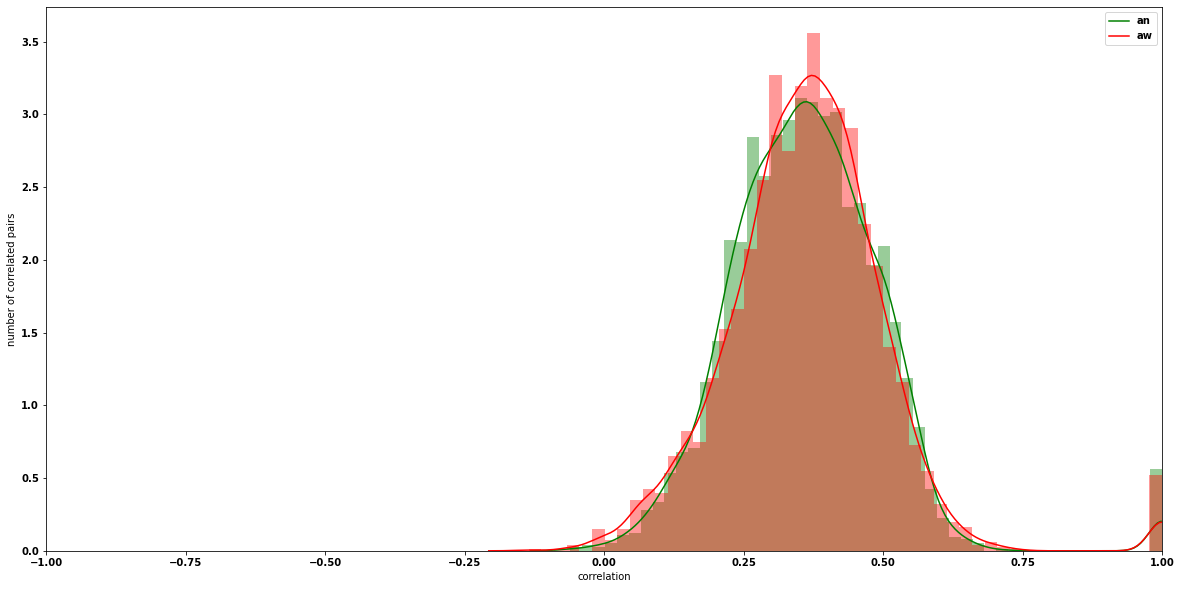

In [17]:
import warnings
warnings.filterwarnings('ignore')

#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        df_an_line = df_corr_an.unstack()
        so1 = df_an_line.sort_values(kind="quicksort")
        df_aw_line = df_corr_aw.unstack()
        so2 = df_aw_line.sort_values(kind="quicksort")

        #plot the correlation distribution
        f, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlim([-1, 1])
        ax.set_xlabel('correlation')
        ax.set_ylabel('number of correlated pairs')
        
        sns.distplot(so1, hist=True, color="g")
        sns.distplot(so2, hist=True, color="r")
        ax.legend(['an', 'aw'])

        break
    break

##### Correlation matrix of All ROI positions 

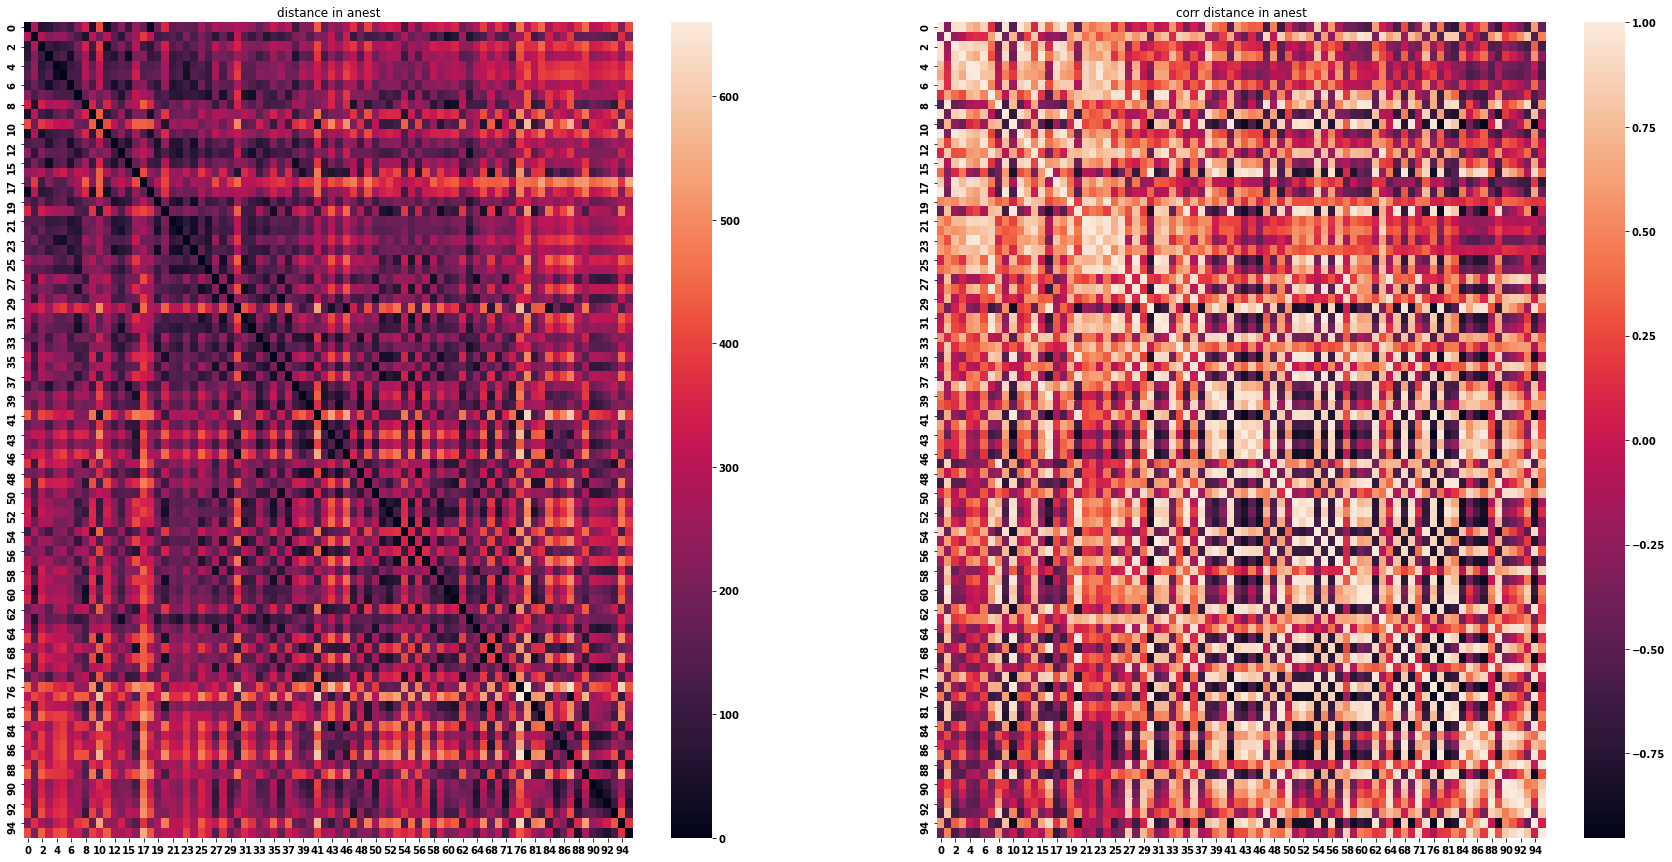

In [18]:
#distances in awake and anestatized state are simmilar, so the plot shows only the anestatized state

#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    pos_tr = roi_load[index[trial-1] : index[trial]+1, :, :, :]

    #choose state
    pos_stan = pos_tr[:, :, 0, :]
    pos_staw = pos_tr[:, :, 1, :]
    
    for sesion in range(4):

        f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(30, 15))

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        pos_sean = pos_stan[:, :, sesion]
        pos_seaw = pos_staw[:, :, sesion]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)
        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)
        
        df_corr_an_pos = pd.DataFrame(index=df_corr_an.index, columns=df_corr_an.columns)
        
        for i in df_corr_an.index:
            for j in df_corr_an.columns:
                df_corr_an_pos.loc[i, j] = np.sqrt((pos_sean[i, 0]-pos_sean[j,0])**2 + (pos_sean[i, 1]-pos_sean[j,1])**2)

        df_corr_an_pos = pd.DataFrame(df_corr_an_pos, index=None).astype(float)
        df_corr_an_pos1 = df_corr_an_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)

        ax1.set_title('distance in anest')
        ax2.set_title('corr distance in anest')

        #plot the correlation matrix
        sns.heatmap(df_corr_an_pos, ax=ax1)
        sns.heatmap(df_corr_an_pos1, ax=ax2)

        break
    break
    

##### Plot of correlations and positions 

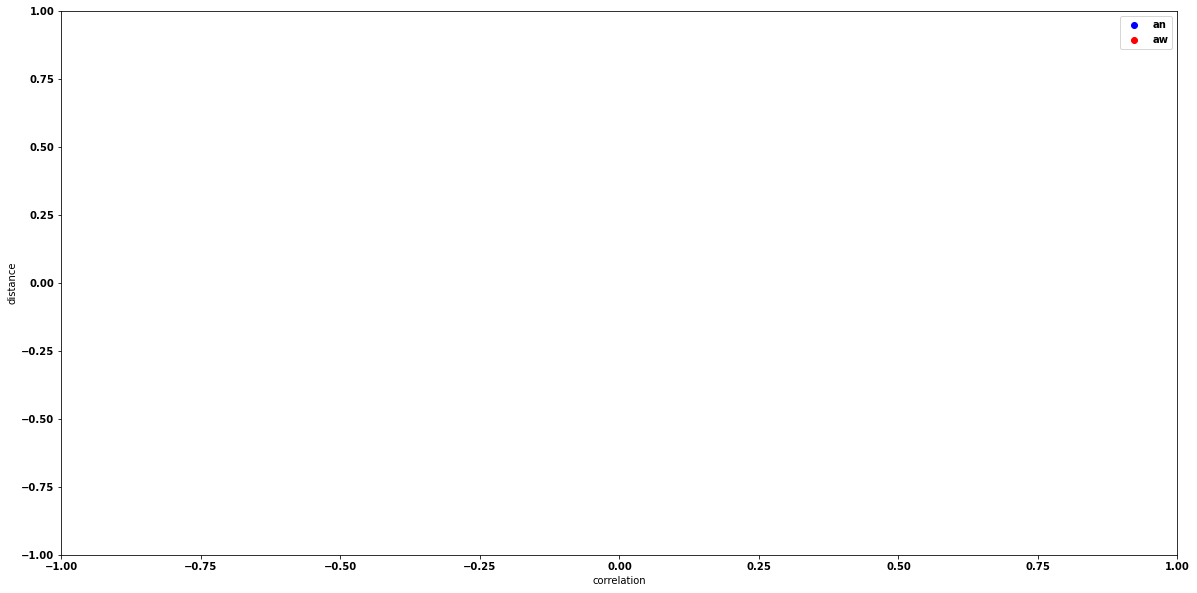

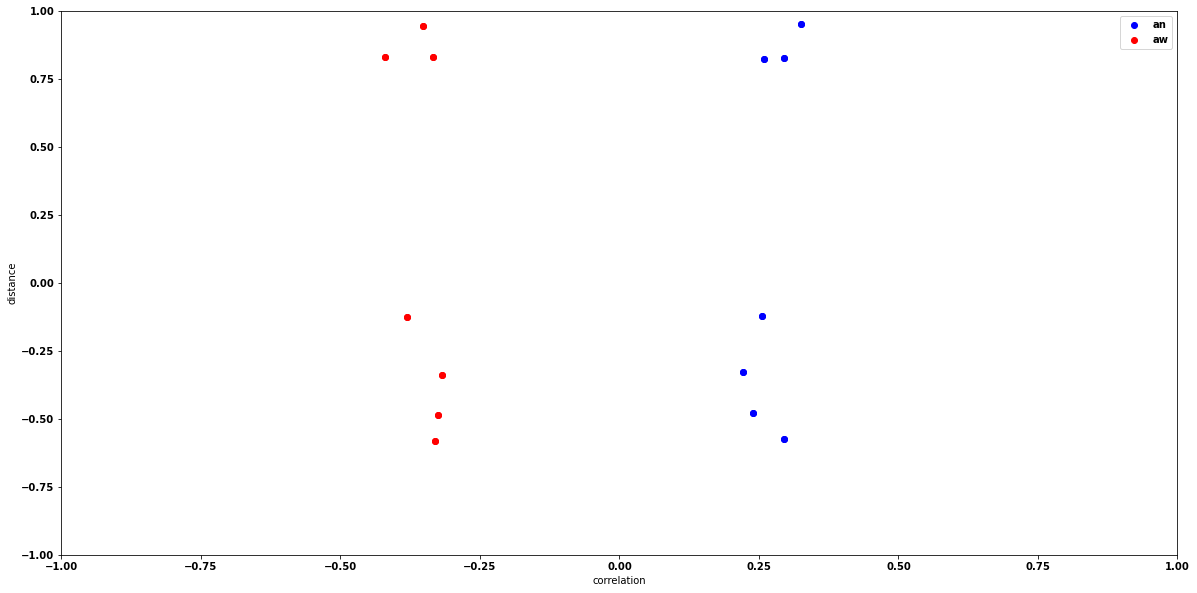

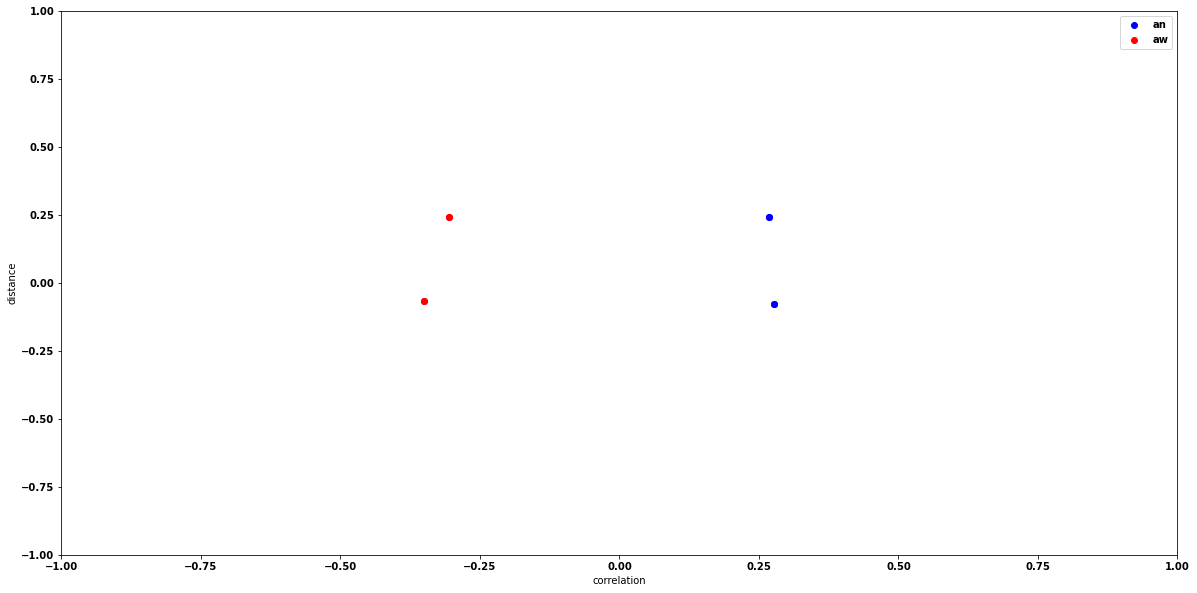

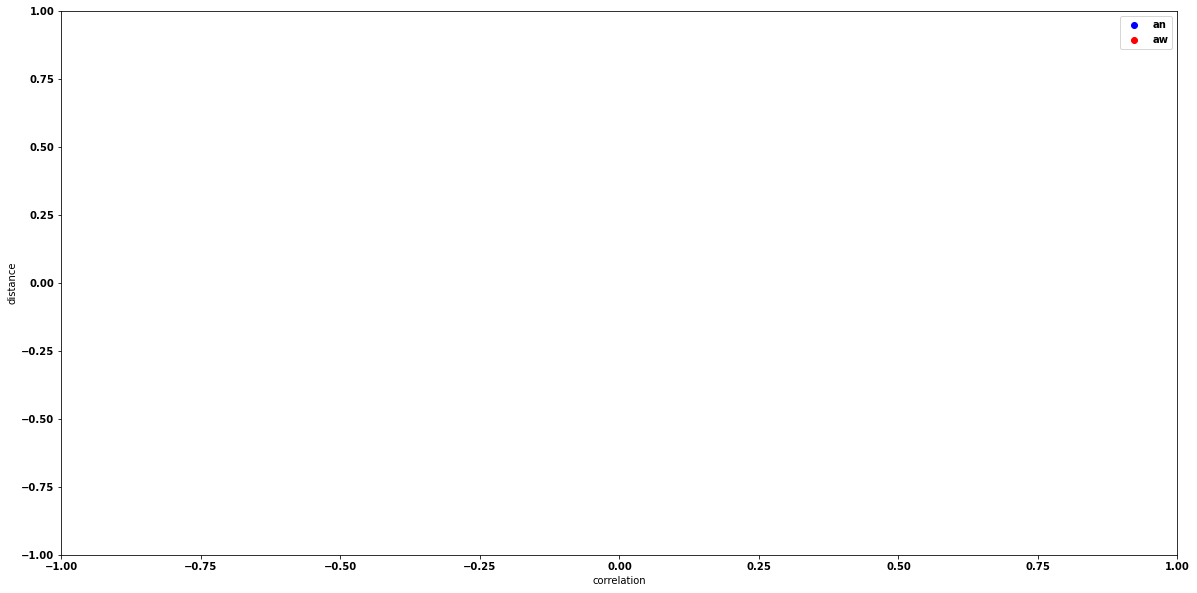

In [19]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    pos_tr = roi_load[index[trial-1] : index[trial]+1, :, :, :]

    #choose state
    pos_stan = pos_tr[:, :, 0, :]
    pos_staw = pos_tr[:, :, 1, :]
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        pos_sean = pos_stan[:, :, sesion]
        pos_seaw = pos_staw[:, :, sesion]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        df_corr_an_pos = pd.DataFrame(index=df_corr_an.index, columns=df_corr_an.columns)
        df_corr_aw_pos = pd.DataFrame(index=df_corr_aw.index, columns=df_corr_aw.columns)
        
        for i in df_corr_an.index:
            for j in df_corr_an.columns:
                df_corr_an_pos.loc[i, j] = np.sqrt((pos_sean[i, 0]-pos_sean[j,0])**2 + (pos_sean[i, 1]-pos_sean[j,1])**2)
                df_corr_aw_pos.loc[i, j] = np.sqrt((pos_seaw[i, 0]-pos_seaw[j,0])**2 + (pos_seaw[i, 1]-pos_seaw[j,1])**2)

        df_corr_an_pos = pd.DataFrame(df_corr_an_pos, index=None).astype(float)
        df_corr_aw_pos = pd.DataFrame(df_corr_aw_pos, index=None).astype(float)
        df_corr_an_pos = df_corr_an_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)
        df_corr_aw_pos = df_corr_aw_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)

        #only look at the anticoorrelated ones in awake condition, and coresponding ones in anesthrized condition
        df_corr_aw[df_corr_aw > -0.3] = nan
        ll = df_corr_aw < -0.3
        df_corr_an = df_corr_an*ll
        df_corr_an[df_corr_an == 0] = nan

        #unstacking the data for plotting
        df_an_line = df_corr_an.unstack()
        df_aw_line = df_corr_aw.unstack()
        df_an_line_pos = df_corr_an_pos.unstack()
        df_aw_line_pos = df_corr_aw_pos.unstack()

        #plot the correlation distribution
        f, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_xlabel('correlation')
        ax.set_ylabel('distance')

        ax.plot(df_an_line, df_an_line_pos, 'o', color='blue', label='activity')
        ax.plot(df_aw_line, df_aw_line_pos, 'o', color='red', label='awakening')
        ax.legend(['an', 'aw'])  
    
    break
    

##### Confusion matrices of correlation tuning between anes and awake state

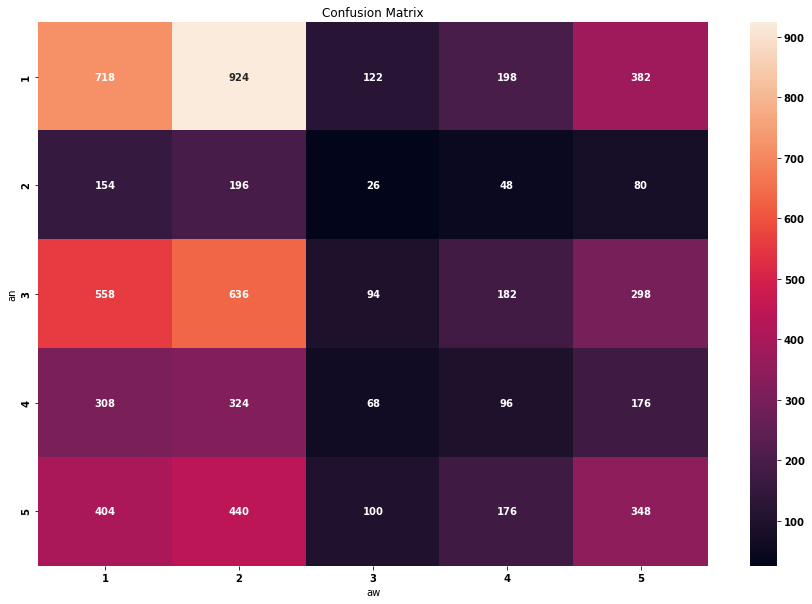

In [20]:
#lenghts of each trial
import matplotlib
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)


for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        all_speakan_corr = pd.DataFrame()
        all_speakaw_corr = pd.DataFrame()

        #make dict to convert to dataframe
        for num in range(0,5):
            dat_df_an, dat_df_aw = make_dict_one_speaker(index, trial, lista[sesion], dat_sean, dat_seaw, num, ind_sean, ind_seaw)
            #exclude the rows/columns which index is not in the other dataframe
            df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)
            #df_corr_an, df_corr_aw = dat_df_an.dropna(how='all', axis=1).dropna(how='all', axis=0), dat_df_aw.dropna(how='all', axis=1).dropna(how='all', axis=0)
            
            df1 = df_corr_an.stack().reset_index()
            #set column names
            df1.columns = ['first', 'second', num+1]
            if(num==0):
                all_speakan_corr = df1
            else:
                all_speakan_corr[num+1] = df1[num+1]
            
            df2 = df_corr_aw.stack().reset_index()
            #set column names
            df2.columns = ['first', 'second', num+1]
            if(num==0):
                all_speakaw_corr = df2
            else:
                all_speakaw_corr[num+1] = df2[num+1]

        m = all_speakan_corr[[1,2,3,4,5]].agg(['idxmax','max'], axis=1).mask(lambda x: x['max'].eq(0))
        all_speakan_corr = all_speakan_corr.join(m, how='left')

        m = all_speakaw_corr[[1,2,3,4,5]].agg(['idxmax','max'], axis=1).mask(lambda x: x['max'].eq(0))
        all_speakaw_corr = all_speakaw_corr.join(m, how='left')
            
        compare = pd.DataFrame()    
        compare['first'], compare['second'] = all_speakan_corr['first'], all_speakan_corr['second']
        compare['an'] = all_speakan_corr['idxmax']
        compare['aw'] = all_speakaw_corr['idxmax']


        cm = confusion_matrix(compare['an'], compare['aw'])

        f,ax = plt.subplots(sharey=False,figsize=(15, 10))
        sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel('aw');ax.set_ylabel('an'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
    
        break
    break

##### Analysis of connections between single neurons based on neurons tuning categories

In [21]:
def tuning_analization(df_corr_an, tune_cat_stan):
    
    all_speakan_corr = df_corr_an.stack().reset_index()
    #set column names
    all_speakan_corr.columns = ['first', 'second', 'corr']

    tuning_1 = []
    br = 0
    for i in range(0, len(all_speakan_corr['first'])-1):
        if(all_speakan_corr['first'][i] != all_speakan_corr['first'][i+1]):
            tuning_1.append(tune_cat_stan[br])
            br+=1
        else:
            tuning_1.append(tune_cat_stan[br])
    tuning_1.append(tune_cat_stan[br])
    all_speakan_corr['tune_1'] = tuning_1 

    return all_speakan_corr

     first  second      corr  tune_1  tune_2
0        1       2  0.532200       1       1
1        1       3  0.518257       1       6
2        1      16  0.503310       1       1
3        1      18  0.511308       1       6
4        1      20  0.525672       1       6
..     ...     ...       ...     ...     ...
838     89      20  0.529970       1       6
839     89      28  0.527842       1       1
840     89      54  0.502982       1       5
841     89      58  0.522526       1       1
850     94      30  0.520822       1       1

[440 rows x 5 columns]


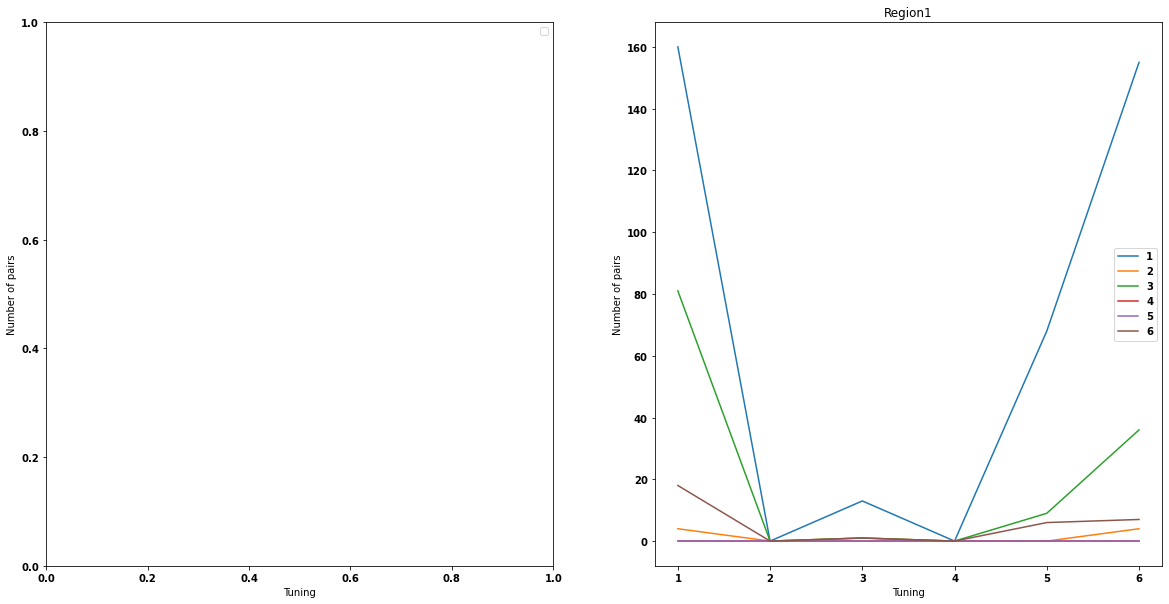

     first  second      corr  tune_1  tune_2
0        0       3  0.509651       1       6
1        0       8  0.522858       1       1
2        0      15  0.513232       1       5
3        0      21  0.533167       1       6
4        0      24  0.524535       1       6
..     ...     ...       ...     ...     ...
115     47      19  0.507520       1       1
116     47      26  0.519233       1       6
117     47      28  0.523535       1       1
118     47      31  0.502246       1       1
119     47      36  0.574540       1       1

[78 rows x 5 columns]


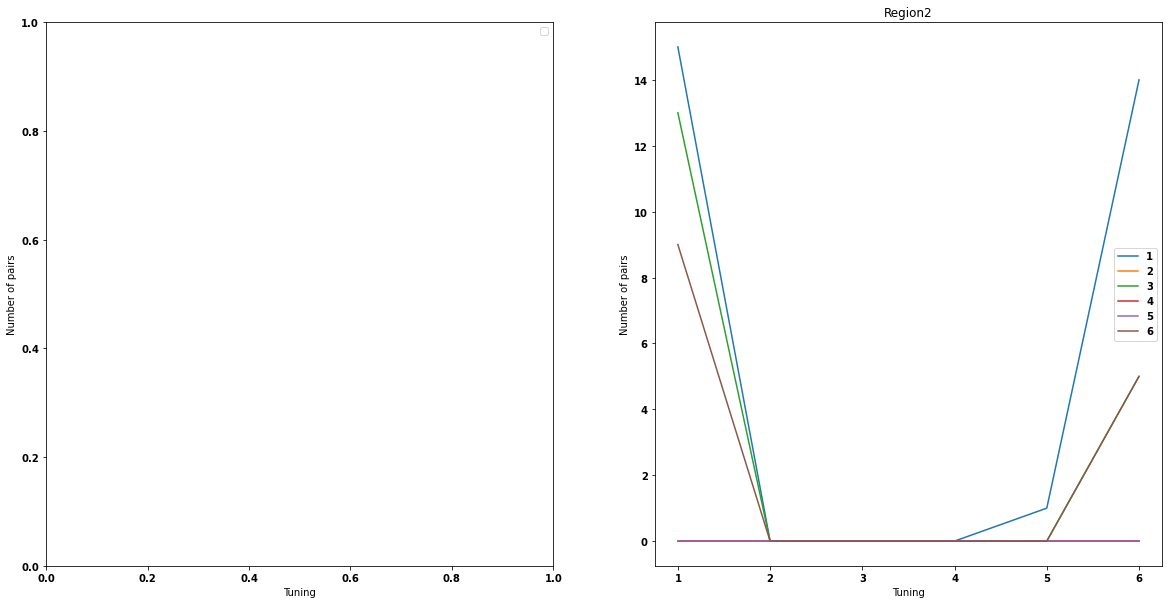

    first  second      corr  tune_1  tune_2
2       7      78  0.546267       1       5
3      10       3  0.749629       1       6
4      10      55  0.591309       1       1
5      10      63  0.557920       1       5
7      55      10  0.591309       1       1
10     65      73  0.533682       1       1
11     65      78  0.505197       1       5
13     73      65  0.533682       1       1


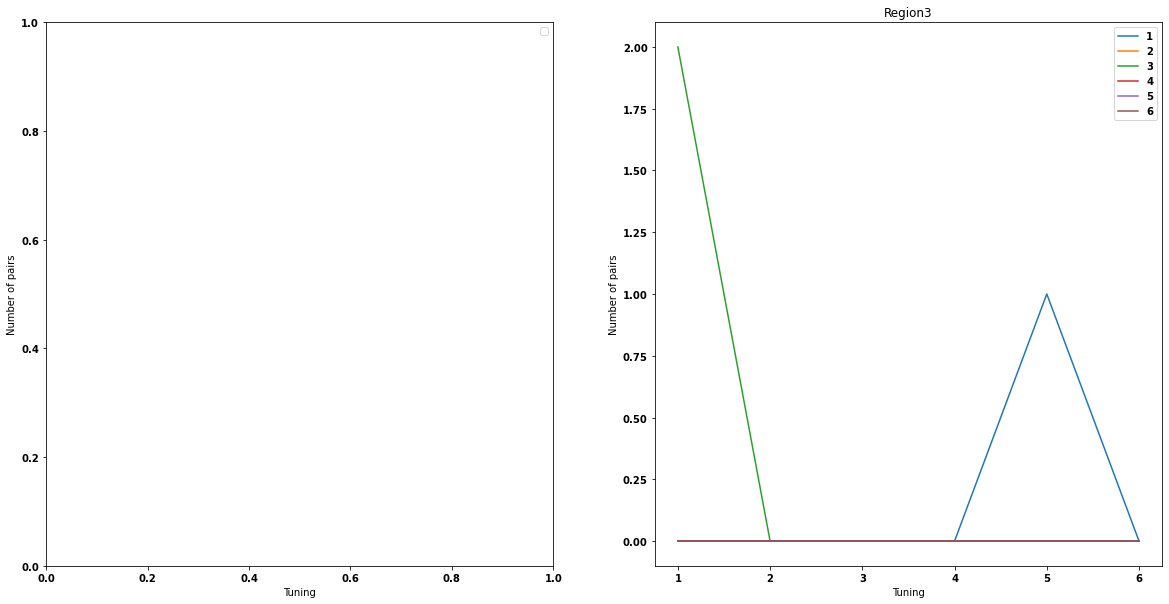

    first  second      corr  tune_1  tune_2
0       0      34  0.543969       1       1
1       8      34  0.563059       1       1
2       9      38  0.533374       1       1
3      15      30  0.506039       1       6
5      31      34  0.504198       1       1
6      34       0  0.543969       1       1
7      34       8  0.563059       1       1
8      34      31  0.504198       1       1
9      34      43  0.517787       1       5
10     34      56  0.567313       1       1
11     34      66  0.533869       1       1
12     38       9  0.533374       1       1
14     56      34  0.567313       1       1
15     66      34  0.533869       1       1


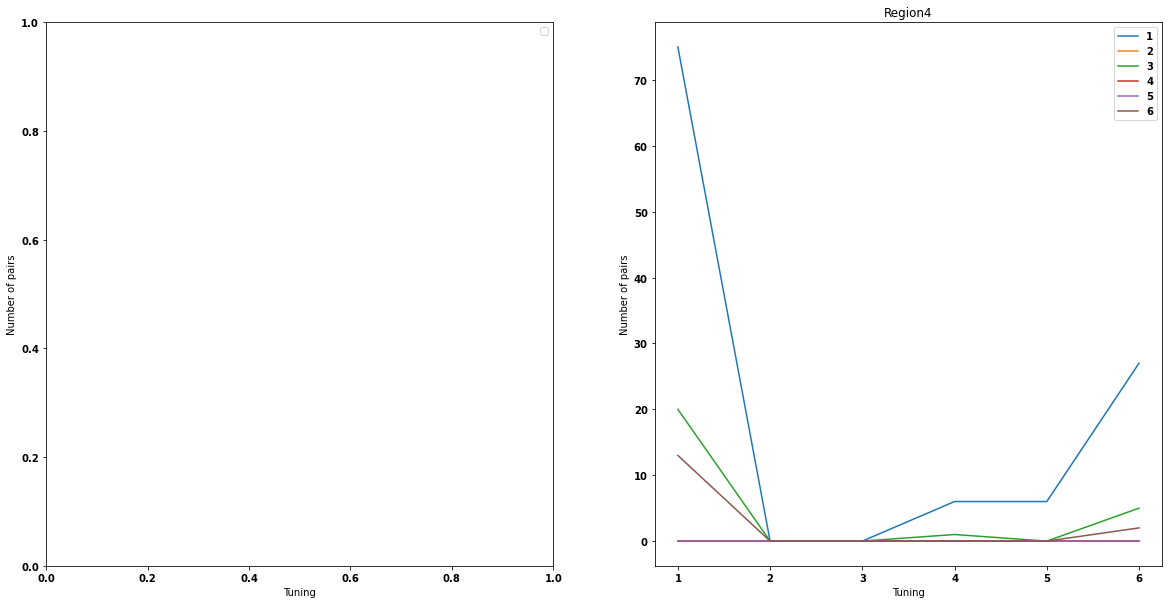

In [61]:
#lenghts of each trial
import matplotlib
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

reg = 1
for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw, ind_stan, ind_staw = divide_data(index, trial, mat_load, ind_load)
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        ind_sean = ind_stan[:, sesion, :, :]
        ind_seaw = ind_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(index, trial, lista[sesion], dat_sean, dat_seaw, ind_sean, ind_seaw)
        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)
        #df_corr_an, df_corr_aw = dat_df_an.dropna(how='all', axis=1).dropna(how='all', axis=0), dat_df_aw.dropna(how='all', axis=1).dropna(how='all', axis=0)
        
        tune_cat_tr = tune_cat[sesion][0 : len(df_corr_an), :, 0]
        tune_cat_stan = tune_cat_tr[:, 0]
        tune_cat_staw = tune_cat_tr[:, 1]

        #analization of the anes tuning
        all_speakan_corr = tuning_analization(df_corr_an, tune_cat_stan)
        #analization of the anes tuning
        all_speakaw_corr = tuning_analization(df_corr_aw, tune_cat_staw)

        tun_pairs = all_speakan_corr[['first', 'tune_1']].drop_duplicates()
        all_speakan_corr['tune_2'] = [int(tun_pairs.loc[tun_pairs['first'] == x]['tune_1']) for x in all_speakan_corr['second']]
        all_speakaw_corr['tune_2'] = [int(tun_pairs.loc[tun_pairs['first'] == x]['tune_1']) for x in all_speakaw_corr['second']]

        all_speakan_corr = all_speakan_corr[all_speakan_corr['first'] != all_speakan_corr['second']]
        all_speakan_corr = all_speakan_corr[all_speakan_corr['corr'] > 0.5]
        all_speakan_corr = all_speakan_corr.reset_index(drop=True)

        all_speakaw_corr = all_speakaw_corr[all_speakaw_corr['first'] != all_speakaw_corr['second']]
        all_speakaw_corr = all_speakaw_corr[all_speakaw_corr['corr'] > 0.5]
        all_speakaw_corr = all_speakaw_corr.reset_index(drop=True)

        f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(20, 10))

        #plotting an tuning
        for i in range(1,7):
            an_spectun = all_speakan_corr[all_speakan_corr['tune_1'] == i]
            num_tun = []
            for j in range(1,7):
                if(i != j):
                    num_tun.append(an_spectun[an_spectun['tune_2'] == j].shape[0])
                else:
                    num_tun.append(int(an_spectun[an_spectun['tune_2'] == j].shape[0]/2))
            ax1.plot(range(1,7), num_tun)
        ax1.legend(['1', '2', '3', '4', '5', '6'])
        ax1.set_xlabel('Tuning');ax1.set_ylabel('Number of pairs')

        #plotting aw tuning
        for i in range(1,7):
            aw_spectun = all_speakaw_corr[all_speakaw_corr['tune_1'] == i]
            num_tun = []
            for j in range(1,7):
                if(i != j):
                    num_tun.append(aw_spectun[aw_spectun['tune_2'] == j].shape[0])
                else:
                    num_tun.append(int(aw_spectun[aw_spectun['tune_2'] == j].shape[0]/2))
            ax2.plot(range(1,7), num_tun)
        ax2.legend(['1', '2', '3', '4', '5', '6'])
        ax2.set_xlabel('Tuning');ax2.set_ylabel('Number of pairs')

        title = "Region" + str(reg)
        reg+=1
        plt.title(title)
        plt.show()
        break